In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home11/mjzhang/gwas_informed_scRNAseq/results'

### Load TMS data 

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
data_facs_ct_scaled = dl.load_tms_ct(DATA_PATH, data_name='facs', flag_scale=True)
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=29.5s


### Load gene annotation

In [4]:
# Get 64 independent traits 
df_sumstats_meta = pd.read_excel(DATA_PATH+'/sumstats/Description_080419.xlsx',
                                 sheet_name='64 Recommended indepent traits')
df_sumstats_meta = df_sumstats_meta[['Trait_Identifier', 'h2g', 'Z', 'N']]

In [5]:
# MAGMA gene annotation
df_geneannot = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.txt', sep='\t')
print('# MAGMA annotation: n_gene=%d, n_trait=%d'%(df_geneannot.shape[0], df_geneannot.shape[1]))

# Ortholog genes 
# (computed using following two lines of codes, stored to void dulplicated computation )
# gp = GProfiler(return_dataframe=True)
# df_orth = gp.orth(organism='hsapiens', query=list(df_geneannot.index), target='mmusculus')
df_orth = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.orth.txt', sep='\t')

# Use only human genes that can be uniquely mapped to a mouse gene
temp_df = df_orth.groupby(['incoming']).agg({'name':len})
gene_list = list(temp_df.index[temp_df['name']==1])
gene_list.sort()
df_orth.index = df_orth['incoming']
df_orth = df_orth.loc[gene_list]
print('# MAGMA annotation: n_mouse_gene_converted=%d'%(df_orth.shape[0]))

# Change df_geneannot genes to mouse genes
dic_mapping = {df_orth['incoming'].values[x]:df_orth['name'].values[x] for x in np.arange(df_orth.shape[0])}
df_geneannot = df_geneannot.loc[gene_list]
df_geneannot.index = [dic_mapping[x] for x in df_geneannot.index]

# MAGMA annotation: n_gene=19427, n_trait=169
# MAGMA annotation: n_mouse_gene_converted=15832


### Benchmark settings

In [6]:
DIC_CONFIG_NAME={'ep_meanmatch_nbc':'random mean-matched\nw/o bc',
                 'ep_random':'random\nn_genebin=100,n_nullset=1',
                 'tp':'theoretical\np-value',}
for n_nullset_ in [1, 5]:
    for n_genebin_ in [200]:
        DIC_CONFIG_NAME['ep_meanmatch_nset%d_nbin%d'%(n_nullset_,n_genebin_)] = \
            'random mean-matched\nn_genebin=%d, n_nullset=%d'%(n_genebin_,n_nullset_)
        
CONFIG_LIST = DIC_CONFIG_NAME.keys()
CONFIG_LIST = list(CONFIG_LIST)

# Generating null gene set

In [7]:
np.random.seed(0)

dic_geneset = {}
dic_trs = {}
gs_size_list = [20,50,200,500]
n_rep=10

df_gene = pd.DataFrame(index=data_facs_ct.var_names)
df_gene['mean'] = data_facs_ct.X.mean(axis=0).T
df_gene = df_gene.sort_values(by=['mean'])

for n_gene in gs_size_list:
    for i_rep in np.arange(n_rep):

        ind_select = np.random.permutation(5000)[:n_gene]
        dic_geneset['null_size%d_highexp_rep%d'%(n_gene,i_rep)] = list(df_gene.index[-5000:][ind_select])
        print('# %-30s n_gene=%d'%('null_size%d_highexp_rep%d'%(n_gene,i_rep),
                                   len(dic_geneset['null_size%d_highexp_rep%d'%(n_gene,i_rep)])))

# null_size20_highexp_rep0       n_gene=20
# null_size20_highexp_rep1       n_gene=20
# null_size20_highexp_rep2       n_gene=20
# null_size20_highexp_rep3       n_gene=20
# null_size20_highexp_rep4       n_gene=20
# null_size20_highexp_rep5       n_gene=20
# null_size20_highexp_rep6       n_gene=20
# null_size20_highexp_rep7       n_gene=20
# null_size20_highexp_rep8       n_gene=20
# null_size20_highexp_rep9       n_gene=20
# null_size50_highexp_rep0       n_gene=50
# null_size50_highexp_rep1       n_gene=50
# null_size50_highexp_rep2       n_gene=50
# null_size50_highexp_rep3       n_gene=50
# null_size50_highexp_rep4       n_gene=50
# null_size50_highexp_rep5       n_gene=50
# null_size50_highexp_rep6       n_gene=50
# null_size50_highexp_rep7       n_gene=50
# null_size50_highexp_rep8       n_gene=50
# null_size50_highexp_rep9       n_gene=50
# null_size200_highexp_rep0      n_gene=200
# null_size200_highexp_rep1      n_gene=200
# null_size200_highexp_rep2      n_gene=200
# null_s

# Checking type 1 control for original data

In [8]:
from scipy.stats import rankdata
def precompute_stats(adata):
    """
    Precompute 
    """
    adata.var['mean'] = data_facs_ct.X.mean(axis=0).T
    v_mean,v_var = util.get_sparse_var(adata.X, axis=1)
    adata.obs['mean'] = v_mean
    adata.obs['var'] = v_var

In [9]:
precompute_stats(data_facs_ct)
precompute_stats(data_facs_ct_scaled)

In [10]:
dic_trs = {}
# # Obtain TRS: This takes a lot of time.
null_trait_list = [x for x in dic_geneset.keys() if 'null' in x]
null_trait_list.sort()
for trait in null_trait_list:
    
    gene_list = list(dic_geneset[trait])
    
    for n_nullset_ in [1, 5]:
        for n_genebin_ in [200]:
    
            # Empirical p, random_mean_match geneset
            md.score_cell(data_facs_ct, gene_list, suffix='', trs_opt='mean', nullset_opt='random_mean_match',
                          n_nullset=n_nullset_, n_genebin=n_genebin_, flag_correct_background=True,
                          return_list=['trs_ep'], verbose=False)
            config_name = 'ep_meanmatch_nset%d_nbin%d'%(n_nullset_,n_genebin_)
            dic_trs['%s.%s'%(config_name,trait)] = data_facs_ct.obs['trs_ep'].values.copy()


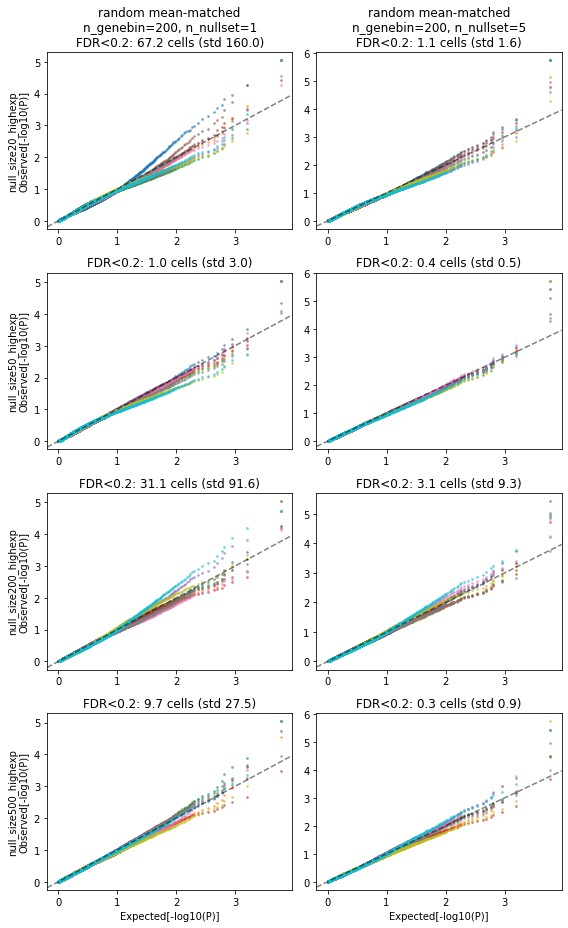

In [11]:
# QQ-plot 
plot_config_list = ['ep_meanmatch_nset1_nbin200', 'ep_meanmatch_nset5_nbin200']
plot_simu_list = ['null_size%d_highexp'%x for x in gs_size_list]

# NOTE that len(1000) 
normal_x = np.random.rand(10000)
normal_x = -np.log10(normal_x)
    
plt.figure(figsize=[3+2.5*len(plot_config_list), 3+2.5*len(plot_simu_list)])

for i_simu,simu in enumerate(plot_simu_list):    
    for i_config,config in enumerate(plot_config_list):
    
        plt.subplot(len(plot_simu_list), len(plot_config_list),i_simu*len(plot_config_list)+i_config+1)
        v_nrej = []
        
        for i_rep in np.arange(n_rep):
            v_p = dic_trs['%s.%s_rep%d'%(config,simu,i_rep)]
            v_fdr = multipletests(v_p, method='fdr_bh')[1]
            v_nlogp = -np.log10(v_p)
            util.qqplot(x=normal_x, y=v_nlogp, quantiles=2000, s=3, alpha=0.5, color='C%d'%i_rep)
            v_nrej.append((v_fdr<0.2).sum())
            
        plt.axline((1, 1), slope=1, linestyle='--', color='k', alpha=0.5)
        v_nrej = np.array(v_nrej)
        if i_simu==0:
            plt.title('%s\nFDR<0.2: %0.1f cells (std %0.1f)'%(DIC_CONFIG_NAME[config],v_nrej.mean(),v_nrej.std()))
        else:
            plt.title('FDR<0.2: %0.1f cells (std %0.1f)'%(v_nrej.mean(),v_nrej.std()))
            
        if i_config==0:
            plt.ylabel('%s\nObserved[-log10(P)]'%simu)
            
        if i_simu==len(plot_simu_list)-1:
            plt.xlabel('Expected[-log10(P)]')
        
plt.tight_layout()
plt.show()

# Checking type 1 error control for scaled data

In [12]:
dic_trs_scaled = {}
# # Obtain TRS: This takes a lot of time.
null_trait_list = [x for x in dic_geneset.keys() if 'null' in x]
null_trait_list.sort()
start_time = time.time()
for trait in null_trait_list:
    
    gene_list = list(dic_geneset[trait])
    
    for n_nullset_ in [1,5]:
        for n_genebin_ in [200]:
    
            # Empirical p, random_mean_match geneset
            md.score_cell(data_facs_ct_scaled, gene_list, suffix='', trs_opt='mean', nullset_opt='random_mean_match',
                          n_nullset=n_nullset_, n_genebin=n_genebin_, flag_correct_background=True,
                          return_list=['trs_ep'], verbose=False)
            config_name = 'ep_meanmatch_nset%d_nbin%d'%(n_nullset_,n_genebin_)
            dic_trs_scaled['%s.%s'%(config_name,trait)] = data_facs_ct_scaled.obs['trs_ep'].values.copy()
        

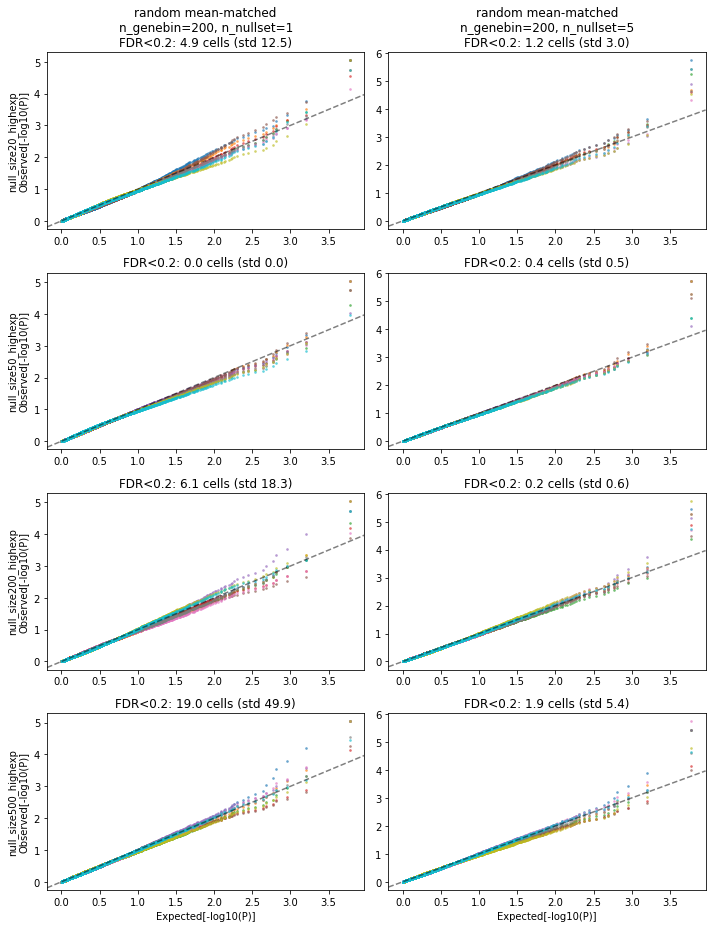

In [13]:
# QQ-plot 
plot_config_list = ['ep_meanmatch_nset1_nbin200', 'ep_meanmatch_nset5_nbin200']
plot_simu_list = ['null_size%d_highexp'%x for x in gs_size_list]

normal_x = np.random.rand(10000)
normal_x = -np.log10(normal_x)
    
plt.figure(figsize=[5+2.5*len(plot_config_list), 3+2.5*len(plot_simu_list)])

for i_simu,simu in enumerate(plot_simu_list):    
    for i_config, config in enumerate(plot_config_list):
    
        plt.subplot(len(plot_simu_list), len(plot_config_list),i_simu*len(plot_config_list)+i_config+1)
        v_nrej = []
        
        for i_rep in np.arange(n_rep):
            v_p = dic_trs_scaled['%s.%s_rep%d'%(config,simu,i_rep)]
            v_fdr = multipletests(v_p, method='fdr_bh')[1]
            v_nlogp = -np.log10(v_p)
            util.qqplot(x=normal_x, y=v_nlogp, quantiles=2000, s=3, alpha=0.5, color='C%d'%i_rep)
            v_nrej.append((v_fdr<0.2).sum())
            
        plt.axline((1, 1), slope=1, linestyle='--', color='k', alpha=0.5)
        v_nrej = np.array(v_nrej)
        if i_simu==0:
            plt.title('%s\nFDR<0.2: %0.1f cells (std %0.1f)'%(DIC_CONFIG_NAME[config],v_nrej.mean(),v_nrej.std()))
        else:
            plt.title('FDR<0.2: %0.1f cells (std %0.1f)'%(v_nrej.mean(),v_nrej.std()))
            
        if i_config==0:
            plt.ylabel('%s\nObserved[-log10(P)]'%simu)
            
        if i_simu==len(plot_simu_list)-1:
            plt.xlabel('Expected[-log10(P)]')
        
plt.tight_layout()
plt.show()

### Test score_cell methods

In [14]:
trait_list = ['PASS_MDD_Wray2018', 'PASS_ADHD_Demontis2018', 'PASS_SCZvsBD_Ruderfer2018',
              'PASS_Coronary_Artery_Disease', 'PASS_CardioembolicStroke_Malik2018', 'PASS_LDL',
              'PASS_Rheumatoid_Arthritis', 'PASS_IBD_deLange2017', 'PASS_Type_1_Diabetes']

tissue_list = list(set(data_facs_ct.obs['tissue']))
tissue_list.sort()
tc_list = list(set(data_facs_ct.obs['tissue_celltype']))
tc_list.sort()

print('# facs data: n_tissue=%d n_tissue_celltype=%d'%(len(tissue_list), len(tc_list)))

# facs data: n_tissue=23 n_tissue_celltype=207


In [15]:
dic_geneset = {}
for trait in trait_list: 
    # Find FDR<0.1 genes 
    temp_v = np.absolute(df_geneannot[trait].values)
    temp_v = 1 - sp.stats.norm.cdf(temp_v)
    temp_v = multipletests(temp_v, method='fdr_bh')[1]
    gene_list = list(df_geneannot.index[temp_v<0.2])
    dic_geneset[trait] = gene_list.copy()
    print('# %-40s n_gene=%d'%(trait, len(gene_list)))

# PASS_MDD_Wray2018                        n_gene=356
# PASS_ADHD_Demontis2018                   n_gene=549
# PASS_SCZvsBD_Ruderfer2018                n_gene=550
# PASS_Coronary_Artery_Disease             n_gene=345
# PASS_CardioembolicStroke_Malik2018       n_gene=111
# PASS_LDL                                 n_gene=731
# PASS_Rheumatoid_Arthritis                n_gene=621
# PASS_IBD_deLange2017                     n_gene=2587
# PASS_Type_1_Diabetes                     n_gene=581


In [19]:
# Obtain TRS
dic_trs = {}
start_time = time.time()
for trait in trait_list:
    
    gene_list = list(dic_geneset[trait])
    
    for n_nullset_ in [1,5]:
        for n_genebin_ in [200]:
    
            # Empirical p, random_mean_match geneset
            md.score_cell(data_facs_ct_scaled, gene_list, suffix='', trs_opt='mean', nullset_opt='random_mean_match',
                          n_nullset=n_nullset_, n_genebin=n_genebin_, flag_correct_background=True,
                          return_list=['trs_ep'], verbose=False)
            config_name = 'ep_meanmatch_nset%d_nbin%d'%(n_nullset_,n_genebin_)
            dic_trs['%s.%s'%(config_name,trait)] = data_facs_ct_scaled.obs['trs_ep'].values.copy()
    
    print('#%-30s time=%0.1fs'%(trait,time.time()-start_time))

#PASS_MDD_Wray2018              time=6.9s
#PASS_ADHD_Demontis2018         time=14.5s
#PASS_SCZvsBD_Ruderfer2018      time=22.0s
#PASS_Coronary_Artery_Disease   time=28.9s
#PASS_CardioembolicStroke_Malik2018 time=34.3s
#PASS_LDL                       time=42.3s
#PASS_Rheumatoid_Arthritis      time=50.1s
#PASS_IBD_deLange2017           time=63.9s
#PASS_Type_1_Diabetes           time=71.4s


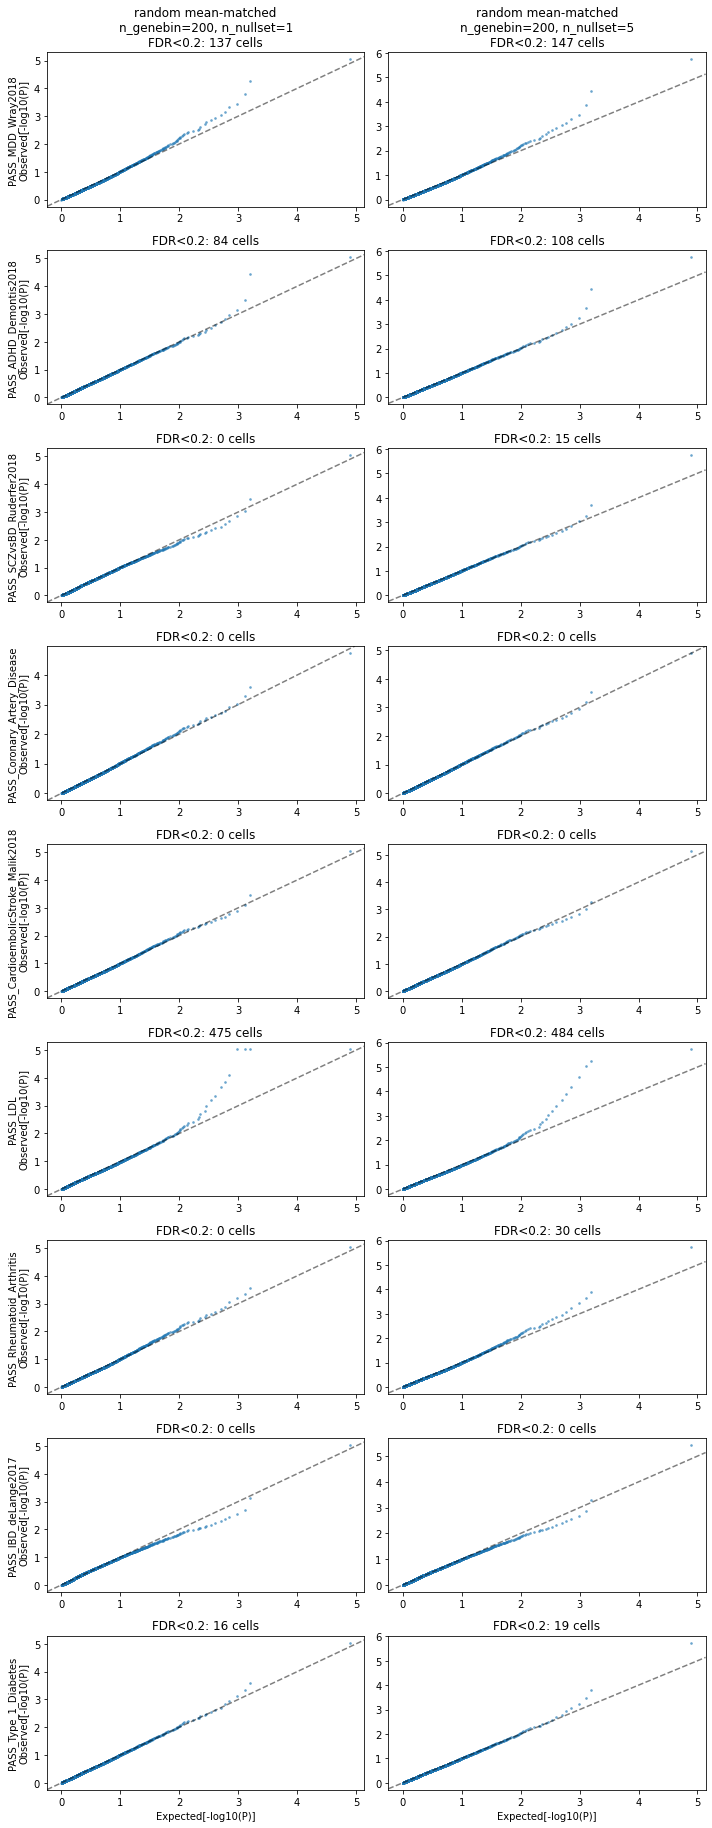

In [20]:
# QQ-plot 
plot_config_list = ['ep_meanmatch_nset1_nbin200',
                    'ep_meanmatch_nset5_nbin200']
plot_trait_list = trait_list

normal_x = np.random.rand(10000)
normal_x = -np.log10(normal_x)
    
plt.figure(figsize=[5+2.5*len(plot_config_list), 3+2.5*len(plot_trait_list)])

for i_trait,trait in enumerate(plot_trait_list):    
    for i_config,config in enumerate(plot_config_list):
        
        v_p = dic_trs['%s.%s'%(config,trait)]
        v_fdr = multipletests(v_p, method='fdr_bh')[1]
        v_nlogp = -np.log10(v_p)
        
        plt.subplot(len(plot_trait_list), len(plot_config_list),i_trait*len(plot_config_list)+i_config+1)
        util.qqplot(x=normal_x, y=v_nlogp, quantiles=2000, s=3, alpha=0.5)
        plt.axline((1, 1), slope=1, linestyle='--', color='k', alpha=0.5)
        
        if i_trait==0:
            plt.title('%s\nFDR<0.2: %d cells'%(DIC_CONFIG_NAME[config],(v_fdr<0.2).sum()))
        else:
            plt.title('FDR<0.2: %d cells'%((v_fdr<0.2).sum()))
            
        if i_config==0:
            plt.ylabel('%s\nObserved[-log10(P)]'%trait)
            
        if i_trait==len(plot_trait_list)-1:
            plt.xlabel('Expected[-log10(P)]')
        
plt.tight_layout()
plt.show()

In [21]:
# Find number of associated cells for each tissue/tissue_celltype

dic_assoc = {'tissue': pd.DataFrame(index=tissue_list, columns=trait_list, data=0),
             'tissue-celltype': pd.DataFrame(index=tc_list, columns=trait_list, data=0)}

df_obs = data_facs_ct_scaled.obs.copy()

for trait in trait_list:
    
    v_p = dic_trs['ep_meanmatch_nset5_nbin200.%s'%trait]
    v_fdr = multipletests(v_p, method='fdr_bh')[1]
    
    # tissue
    temp_df = df_obs.loc[v_fdr<0.2].copy()
    temp_df = temp_df.groupby(['tissue']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue'].loc[temp_df.index, trait] = temp_df['cell'].values
    
    # tissue-cell
    temp_df = df_obs.loc[v_fdr<0.2].copy().copy()
    temp_df = temp_df.groupby(['tissue_celltype']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue-celltype'].loc[temp_df.index, trait] = temp_df['cell'].values

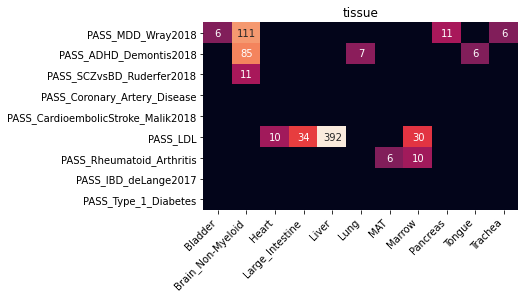

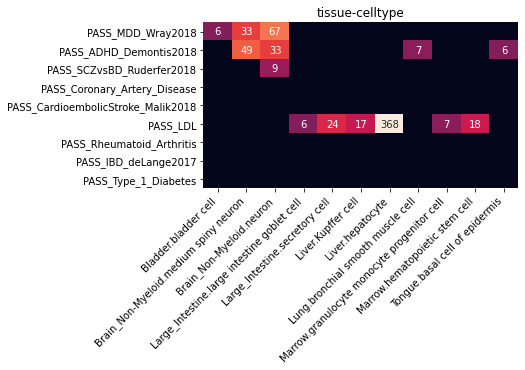

In [22]:
def num2str(x):
    if x>1000:
        return '%0.1fk'%(x/1000)
    elif x>0:
        return '%d'%x
    else:
        return ''
    
for term in dic_assoc.keys():

    df_plot = dic_assoc[term].copy()
    df_plot = df_plot.loc[df_plot.max(axis=1)>5]
    df_plot = df_plot.T
    df_plot[df_plot<5] = 0
    
    mat_annot = np.zeros(df_plot.shape, dtype=object)
    for i_col,col in enumerate(df_plot.columns):
        mat_annot[:,i_col] = [num2str(x) for x in df_plot[col].values]
    df_plot = np.log10(df_plot+1)
    
    plt.figure(figsize=[0.4*df_plot.shape[1]+3, 0.25*df_plot.shape[0]+2+1*('tissue-celltype' in term)])
    sns.heatmap(df_plot, annot=mat_annot, fmt='s', cbar=False)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.title(term)
    plt.tight_layout()
    plt.show()